# Exploratory Data Analysis

In [87]:
#import libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
from datetime import datetime, date, timedelta
from pandas import DataFrame
import requests
import json
import random
import os.path

# RKI Case Numbers

In [97]:
#Download data set to explore case numbers
if os.path.isfile('bundesland_cases.csv'):
    bundesland_cases = pd.read_csv('bundesland_cases.csv', encoding='iso-8859-1')
else:
    url = "https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv"
    data = pd.read_csv(url,
                     encoding= 'utf8', 
                     usecols=['Bundesland', 'AnzahlFall', 'Meldedatum'],
                     parse_dates=['Meldedatum'])
    bundesland_cases = data.groupby(['Bundesland', 'Meldedatum'], as_index = False)['AnzahlFall'].sum()
    bundesland_cases = bundesland_cases.set_index("Meldedatum").sort_index()
    bundesland_cases.to_csv("bundesland_cases.csv")
    
print(bundesland_cases)

      Meldedatum           Bundesland  AnzahlFall
0     2020-01-02  Nordrhein-Westfalen           1
1     2020-01-12  Nordrhein-Westfalen           1
2     2020-01-14  Nordrhein-Westfalen           1
3     2020-01-18          Brandenburg           1
4     2020-01-28               Bayern           2
...          ...                  ...         ...
4537  2020-12-17   Schleswig-Holstein         469
4538  2020-12-17               Hessen        1029
4539  2020-12-17               Bremen         146
4540  2020-12-17               Bayern        3804
4541  2020-12-17           ThÃ¼ringen        1078

[4542 rows x 3 columns]


                Bundesland  AnzahlFall
0        Baden-Württemberg      202050
1                   Bayern      277953
2                   Berlin       83669
3              Brandenburg       30092
4                   Bremen       12231
5                  Hamburg       31038
6                   Hessen      115453
7   Mecklenburg-Vorpommern        9227
8            Niedersachsen       91145
9      Nordrhein-Westfalen      339124
10         Rheinland-Pfalz       60752
11                Saarland       17109
12                 Sachsen       98829
13          Sachsen-Anhalt       20854
14      Schleswig-Holstein       19791
15               Thüringen       30274


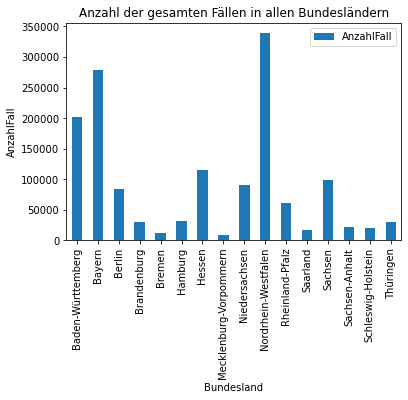

In [5]:
# accumulate cases per Bundesland

bundesland_cases_sum = data.groupby(['Bundesland'], as_index = False)['AnzahlFall'].sum()
print(bundesland_cases_sum)
bundesland_cases_sum.plot(x ='Bundesland', y='AnzahlFall', kind = 'bar')

plt.title('Anzahl der gesamten Fällen in allen Bundesländern')
plt.xlabel('Bundesland')
plt.ylabel('AnzahlFall')
plt.show()

Folgende Schritte werden analysiert:
- Wir haben festgestellt, dass die meisten Cases in folgenden Bundesländer vorkommen:
  Baden-Württemberg, Bayern, Berlin, Hessen, Neidersachsen, NRW, Rheinland-Pfalz und Sachsen. Diese würden wir   ein bisschen genauer anschauen, um festzustellen, welche Maßnahmen dort eingeführt waren
- Und umgekehrt wollen wir die Bunderländer betrachten, die nicht so viele Anzahl der Fällen enthalten, welche Maßnahmen sind dort eingeführt
- Vergleichen die beiden Ergebnisse -> Abhängigkeiten herausfinden?



                Bundesland  AnzahlFall
4                   Bremen     12231.0
7   Mecklenburg-Vorpommern      9227.0
11                Saarland     17109.0
13          Sachsen-Anhalt     20854.0
14      Schleswig-Holstein     19791.0


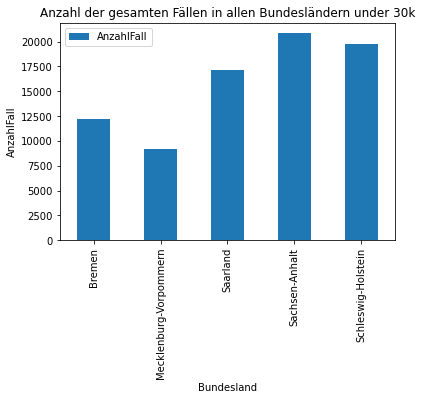

In [6]:
# making filter series for under 30k cases
filter = bundesland_cases_sum["AnzahlFall"]<30000
  
# filtering data on basis of both filters 
bundesland_cases_sum_under_30k = bundesland_cases_sum.where(filter).dropna()

print(bundesland_cases_sum_under_30k)
bundesland_cases_sum_under_30k.plot(x ='Bundesland', y='AnzahlFall', kind = 'bar')

plt.title('Anzahl der gesamten Fällen in allen Bundesländern under 30k')
plt.xlabel('Bundesland')
plt.ylabel('AnzahlFall')
plt.show()

Todo:
- r-value graph per BL
- incidence graph per BL

# Coronanet

In [91]:
if os.path.isfile('restriction_data.csv'):
    restriction_data = pd.read_csv('restriction_data.csv', encoding='iso-8859-1')
else:
    #not working with current online dataset
    #download data for restriction measures
    country = "Germany"
    url = "https://raw.githubusercontent.com/saudiwin/corona_tscs/master/data/CoronaNet/data_country/coronanet_release/coronanet_release_{0}.csv".format(country)
    restriction_data = pd.read_csv(url, encoding='iso-8859-1')
    restriction_data.to_csv("restriction_data.csv")
print("Shape: ", restriction_data.shape)

Shape:  (2461, 42)


In [86]:
#print(restriction_data)

restriction_data['target_province'] = restriction_data['target_province'].str.replace(';','')
restriction_data['target_province'] = restriction_data['target_province'].str.replace(r'^-$','Countrywide')
restriction_data[(restriction_data.target_province.isin(['-', np.nan]))] = restriction_data[(restriction_data.target_province.isin(['-', np.nan]))].assign(target_province = 'Countrywide')

#filter=restriction_data["target_province"].str.contains('Berlin')
#add condition init_country_level = "Provincial" (, "Municipal")
#restriction_data_for_berlin = restriction_data.where(filter)#.dropna()
restriction_data_for_berlin = restriction_data[(restriction_data['target_province'] == 'Berlin') & (restriction_data['init_country_level'] == 'Provincial')]
#restriction_data_for_berlin.to_csv("restriction_data_for_berlin.csv")
restriction_data_for_berlin.drop()
print(restriction_data_for_berlin)

      Unnamed: 0  Unnamed: 0.1            record_id  policy_id entry_type  \
77            77            78  R_2usPauyCUO0AP6dDf    3951109     update   
78            78            79  R_3Mz2tnpKdhei50TEd    3951109     update   
79            79            80  R_3Mz2tnpKdhei50TBo    3951109     update   
86            86            87  R_AvUCTm3WwZfeqWtDf    1223207     update   
87            87            88  R_AvUCTm3WwZfeqWtDh    1223207     update   
...          ...           ...                  ...        ...        ...   
2366        2366          2367  R_OGVMycYUR1xdsWJFj    2278276  new_entry   
2367        2367          2368  R_OGVMycYUR1xdsWJFi    2278276  new_entry   
2368        2368          2369  R_OGVMycYUR1xdsWJFl    2278276  new_entry   
2383        2383          2384  R_2saSmekaVFEwc88NA    9269797     update   
2413        2413          2414  R_8f4U6A9SkQPIyLTCt    3522905  new_entry   

     correct_type       update_type   update_level  \
77       original    

List of all unique measures in Germany

In [85]:
print(restriction_data["type_sub_cat"].unique())

[nan 'Higher education institutions (i.e. degree granting institutions)'
 'Preschool or childcare facilities (generally for children ages 5 and below)'
 'Primary Schools (generally for children ages 10 and below)'
 'Secondary Schools (generally for children ages 10 to 18)'
 'Other External Border Restriction'
 'Health Screenings (e.g. temperature checks)'
 'Travel History Form (e.g. documents where traveler has recently been)'
 'Visa extensions (e.g. visa validity extended)' 'Health Certificates'
 'Hand Sanitizer' 'Other Health Materials' 'Temporary Medical Centers'
 'Public Testing Facilities (e.g. drive-in testing for COVID-19)'
 'Health Research Facilities' 'Ventilators' 'Unspecified Health Materials'
 'Hospitals' 'Other Heath Staff' 'Doctors'
 'Unspecified Health Infrastructure' 'Nurses' 'Health Volunteers'
 'Unspecified Health Staff' 'Masks' 'Other Health Infrastructure'
 'Personal Protective Equipment' 'Temporary Quarantine Centers'
 'Medicine/Drugs' 'Vaccines' 'Test Kits'
 'Fixe

Todo:
- List of all unique measures in Germany with category
- Comparison, number of measures in different BL (Ranking), maybe add case numbers
- List of countrywide measures
- maybe: ranking, most popular/long-lived measures
- maybe: timeline of all measures per BL